# Monte-Carlo Case Study using Nigeria's Power Data
This Jupyter Notebook serves as a case study for analyzing simulations created using Monte-Carlo method applied to Nigeria's power data.

## Introduction

The goal of this notebook is to analyze the results of the Monte-Carlo simulations and gain insights into the power system of Nigeria. It utilizes the Monte Carlo method to generate multiple scenarios and assess the uncertainty in the power system's performance.

The Monte Carlo method is a statistical technique that involves running multiple simulations with randomly sampled input parameters to estimate the distribution of the output variables. By applying this method to Nigeria's power data, we can assess the reliability and robustness of the power system under different scenarios and identify potential areas for improvement.

By following this notebook, you will be able to understand the applied Monte-Carlo methodology, explore the power system simulations, and gain insights into Nigeria's power data.


## Sensitivity Analysis

Sensitivity analysis helps us explore how variations in input parameters affect the model’s output. These inputs might include energy prices, efficiency factors, renewable energy availability, and demand patterns.

Decision-makers use this information to understand the implications of different choices on system performance and costs. 
Energy models inform policy decisions. Sensitivity analysis helps policymakers understand which factors drive energy transitions. 

Additionally, sensitivity analysis guides resource allocation by pinpointing critical variables for optimal solutions. It aids in communicating uncertainties to stakeholders and informs scenario planning for future energy scenarios. The analysis also validates models by checking if changes in parameters align with expected outcomes, ensuring model reliability.

### Loading Neccessary Libraries

In [1]:
# change current directory to parent folder
import os
import sys

if not os.path.isdir("pypsa-earth"):
    os.chdir("../..")
sys.path.append(os.getcwd()+"/pypsa-earth/scripts")


In [2]:
import os
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import statsmodels.api as sm
from scipy.stats.mstats import zscore
from scipy import stats
from scripts.monte_carlo import (
            monte_carlo_sampling_pydoe2, monte_carlo_sampling_scipy, 
            monte_carlo_sampling_chaospy, validate_parameters)
import logging
import yaml
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)

# disable logging from imported modules 
logging.disable(sys.maxsize)

/Users/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


In [3]:
# load the config file used for the monte carlo simulation
with open("mc/pypsa-earth/config.yaml", "r") as stream:
    config = yaml.safe_load(stream)["monte_carlo"]

### Loading simulation results

In [6]:
!pwd

/Users/gbotemi/Documents/code/PYPSA


In [7]:
# load solved networks into a list
network_list = []

for count in range(0,49):
    # set directory of solved networks in results folder
    path = f"mc/pypsa-earth/results/NG/networks/elec_s_10_ec_lcopt_Co2L-24H_m{count}.nc"
    network = pypsa.Network(path)
    network_list.append(network)

print("All Networks loaded successfully")

All Networks loaded successfully


In [8]:
# load network objective values
network_obejective_list = []

for idx in network_list:
    obj = idx.objective / 1e9
    network_obejective_list.append(obj)
print("objective loaded completely")

objective loaded completely


### Reproducing the Parameters for Monte-Carlo Simulation

In [9]:
MONTE_CARLO_PYPSA_FEATURES = [
    k for k in config["uncertainties"].keys() if k
]  # removes key value pairs with empty value e.g. []
MONTE_CARLO_OPTIONS = config["options"]
N_FEATURES = len(
    MONTE_CARLO_PYPSA_FEATURES
)  # only counts features when specified in config
SAMPLES = MONTE_CARLO_OPTIONS.get(
    "samples"
)  # TODO: What is the optimal sampling? Fabian Neumann answered that in "Broad ranges" paper
SAMPLING_STRATEGY = MONTE_CARLO_OPTIONS.get("sampling_strategy")
UNCERTAINTIES_VALUES = config["uncertainties"].values()
SEED = MONTE_CARLO_OPTIONS.get("seed")

# PARAMETERS VALIDATION
# validates the parameters supplied from config file
validate_parameters(SAMPLING_STRATEGY, SAMPLES, UNCERTAINTIES_VALUES)

# SCENARIO CREATION / SAMPLING STRATEGY
###
if SAMPLING_STRATEGY == "pydoe2":
    lh = monte_carlo_sampling_pydoe2(
        N_FEATURES,
        SAMPLES,
        UNCERTAINTIES_VALUES,
        random_state=SEED,
        criterion=None,
        iteration=None,
        correlation_matrix=None,
    )
if SAMPLING_STRATEGY == "scipy":
    lh = monte_carlo_sampling_scipy(
        N_FEATURES,
        SAMPLES,
        UNCERTAINTIES_VALUES,
        seed=SEED,
        strength=2,
        optimization=None,
    )
if SAMPLING_STRATEGY == "chaospy":
    lh = monte_carlo_sampling_chaospy(
        N_FEATURES, SAMPLES, UNCERTAINTIES_VALUES, seed=SEED, rule="latin_hypercube"
    )

In [10]:
# reassign the values of the parameters and the objective values from the solved network
x = lh
y = network_obejective_list

### Standardised Regression Coefficient

Standardised Regression Coefficient otherwise known as beta corefficients shows how much the outcome (dependent variable) changes when one input (independent variable) changes 

In [11]:
src = sm.OLS(zscore(y), zscore(x)).fit()
src_beta_coefficients = src.params

In [12]:
src.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.668
Model:                            OLS   Adj. R-squared (uncentered):              0.613
Method:                 Least Squares   F-statistic:                              12.08
Date:                Fri, 01 Mar 2024   Prob (F-statistic):                    2.50e-08
Time:                        04:41:46   Log-Likelihood:                         -42.506
No. Observations:                  49   AIC:                                      99.01
Df Residuals:                      42   BIC:                                      112.3
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7293      0.093      7.834      0.000       0.541       0.917
x2            -0.1198      0.094     -1.276      0.209      -0.309       0.070
x3            -0.1697      0.100     -1.703      0.096      -0.371       0.031
x4             0.3370      0.098      3.436      0.001       0.139       0.535
x5             0.1826      0.096      1.898      0.065      -0.012       0.377
x6            -0.0295      0.097     -0.303      0.763      -0.226       0.167
x7            -0.0671      0.092     -0.728      0.470      -0.253       0.119
==============================================================================
Omnibus:                        7.069   Durbin-Watson:                   2.258
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                7.828
Skew:                          -0.487   Prob(JB):                       0.0200
Kurtosis:                       4.699   Cond. No.                         1.96
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

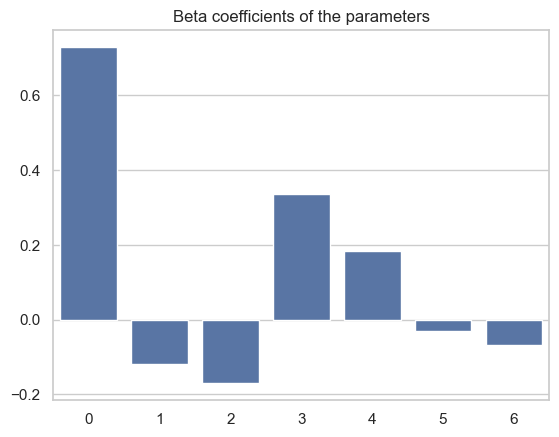

In [13]:
sns.barplot(src_beta_coefficients)
plt.title("Beta coefficients of the parameters")
plt.show()

Here is labelling for the x-axis of the plots with regards to the selected parameters

0: 'loads_t.p_set <br>
1: 'generators_t.p_max_pu.loc[:, n.generators.carrier == "solar"]'<br>
2: 'generators_t.p_max_pu.loc[:, n.generators.carrier == "onwind"]'<br>
3: 'generators.capital_cost.loc[n.generators.carrier == "solar"]'<br>
4: 'generators.capital_cost.loc[n.generators.carrier == "onwind"]'<br>
5: 'generators.weight.loc[n.generators.carrier == "onwind"]'<br>
6: 'generators.weight.loc[n.generators.carrier == "solar"]

### Partial Correlation Coefficients

Partial Correlation Coefficients measures the strength of the relationship between two variables while removing the influence of other factors

In [14]:
pcc = np.zeros(shape=(x.shape[1],))

for idx in range(x.shape[1]):
    r, _ = stats.pearsonr(x[:,idx], y)
    pcc[idx] = r


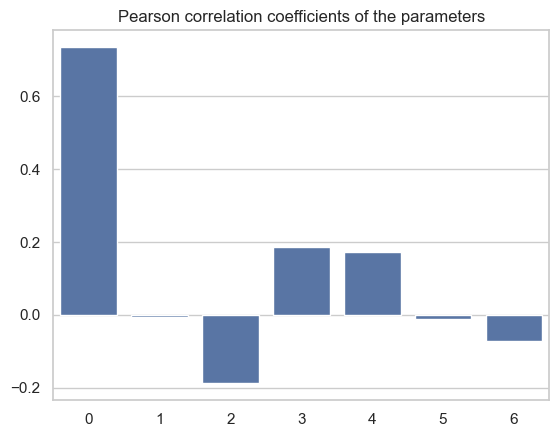

In [15]:
sns.barplot(pcc)
plt.title("Pearson correlation coefficients of the parameters")
plt.show()

_The same labelling earlier applies to this plot_

Certainly, Based on the sensitvity analysis performed with PCC and SRC, we can draw that the `load` parameter has a higher importance when compared to the other parameters.